# Installing dependencies

In [ ]:
!pip install roboflow
!pip install ultralytics

# Downloading BCCD dataset from Roboflow

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace("joseph-nelson").project("bccd")
version = project.version(4)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BCCD-4 in yolov11:: 100%|██████████| 1760/1760 [00:00<00:00, 8933.01it/s]


# Training the YOLOv11 on BCCD

In [3]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.7/112.6 GB disk)


In [ ]:
# Train YOLO11n
# !yolo train model=yolo11n.pt data=/content/BCCD-4/data.yaml epochs=100 imgsz=416

# Defining custom validator and predector

In [4]:
import torch
import torchvision
from ultralytics.utils import ops
from ultralytics.engine.results import Results
from ultralytics.models.yolo.detect import DetectionValidator, DetectionPredictor

class CustomValidator(DetectionValidator):
    def postprocess(self, preds):
        preds = ops.non_max_suppression(
            preds,
            self.args.conf,
            self.args.iou,
            labels=self.lb,
            multi_label=True,
            agnostic=self.args.single_cls or self.args.agnostic_nms,
            max_det=self.args.max_det,
        )

        for i, pred in enumerate(preds):
          x = torch.cat((pred[pred[:, 5] == 0], torch.argwhere(pred[:, 5] == 0)), 1)
          idx = torchvision.ops.nms(x[:, :4], x[:, 4], 0.1)
          idx = torch.cat((x[idx][:, 6], torch.squeeze(torch.argwhere(pred[:, 5] != 0))))
          preds[i] = pred[idx.int()]

        return preds

class CustomPredictor(DetectionPredictor):
    def postprocess(self, preds, img, orig_imgs):
        preds = ops.non_max_suppression(
            preds,
            self.args.conf,
            self.args.iou,
            agnostic=self.args.agnostic_nms,
            max_det=self.args.max_det,
            classes=self.args.classes,
        )

        for i, pred in enumerate(preds):
          x = torch.cat((pred[pred[:, 5] == 0], torch.argwhere(pred[:, 5] == 0)), 1)
          idx = torchvision.ops.nms(x[:, :4], x[:, 4], 0.1)
          idx = torch.cat((x[idx][:, 6], torch.squeeze(torch.argwhere(pred[:, 5] != 0))))
          preds[i] = pred[idx.int()]

        if not isinstance(orig_imgs, list):
            orig_imgs = ops.convert_torch2numpy_batch(orig_imgs)

        results = []
        for pred, orig_img, img_path in zip(preds, orig_imgs, self.batch[0]):
            pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
            results.append(Results(orig_img, path=img_path, names=self.model.names, boxes=pred))
        return results

# Measuring accuracy

In [5]:
import os
import numpy as np
from pathlib import Path


def acc(path_model, test_image, test_label, predictor=None, show=False):
  model_path = path_model
  test_images = test_image
  test_labels = test_label

  model = YOLO(model_path)
  results = model.predict(test_images, conf=0.5, show=False, verbose=False ,predictor=predictor)

  predictions = {k: 0 for k in results[0].names.keys()}
  for r in results:
    prediction = dict(zip(*np.unique(r.boxes.cls.cpu().numpy(), return_counts=True)))
    predictions = {k: predictions.get(k, 0) + prediction.get(k, 0) for k in set(predictions) | set(prediction)}


  labels = {k: 0 for k in results[0].names.keys()}
  files = Path(test_labels).glob('*')
  for file in files:
    x = os.path.join(test_labels, file)
    for line in open(file, 'r').readlines():
      labels[int(line[0])] += 1

  accuracy = {k: (1 - abs(labels[k] - predictions[k]) / labels[k]) * 100 for k in labels.keys()}

  if show:
    print("Labels for each class:")
    for l in labels.keys():
      print(f"  {l}: {round(labels[l], 2)}")

    print("\nModel predictions for each class:")
    for p in predictions.keys():
      print(f"  {p}: {round(predictions[p], 2)}")

    print("\nAccuracy for each class:")
    for a in accuracy.keys():
      print(f"  {a}: {round(accuracy[a], 2)}%")

  return labels, predictions, accuracy


# Loading model

In [6]:
# Load the model
model_path = '/content/best.pt'
model = YOLO(model_path)

# Evaluation on validation set without KNN

In [7]:
results = model.val(data="/content/BCCD-4/data.yaml", conf=0.5)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 79.1MB/s]
val: Scanning /content/BCCD-4/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1060.57it/s]

val: New cache created: /content/BCCD-4/valid/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.13it/s]


                   all         73        967      0.873      0.901      0.907       0.67
             Platelets         42         76      0.829      0.895      0.889      0.543
                   RBC         72        819      0.818       0.81      0.842      0.633
                   WBC         71         72      0.973          1       0.99      0.834
Speed: 2.4ms preprocess, 4.2ms inference, 0.0ms loss, 10.5ms postprocess per image
Results saved to runs/detect/val


In [11]:
# validation accuracy
images = "/content/BCCD-4/valid/images"
labels = "/content/BCCD-4/valid/labels"
_ = acc(model_path, images, labels, show=True)

Labels for each class:
  0: 76
  1: 819
  2: 72

Model predictions for each class:
  0: 87
  1: 1025
  2: 74

Accuracy for each class:
  0: 85.53%
  1: 74.85%
  2: 97.22%


# Evaluation on validation set with KNN

In [10]:
results = model.val(data="/content/BCCD-4/data.yaml", conf=0.5, validator=CustomValidator)

Ultralytics 8.3.54 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/BCCD-4/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


                   all         73        967      0.873      0.897      0.905      0.669
             Platelets         42         76      0.827      0.882      0.882       0.54
                   RBC         72        819      0.818       0.81      0.842      0.633
                   WBC         71         72      0.973          1       0.99      0.834
Speed: 1.8ms preprocess, 4.0ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/val2


In [12]:
# validation accuracy with knn
images = "/content/BCCD-4/valid/images"
labels = "/content/BCCD-4/valid/labels"
_ = acc(model_path, images, labels, predictor=CustomPredictor, show=True)

Labels for each class:
  0: 76
  1: 819
  2: 72

Model predictions for each class:
  0: 86
  1: 1025
  2: 74

Accuracy for each class:
  0: 86.84%
  1: 74.85%
  2: 97.22%


# Example

## Without KNN


0: 416x416 2 Plateletss, 16 RBCs, 1 WBC, 8.3ms
Speed: 0.9ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)


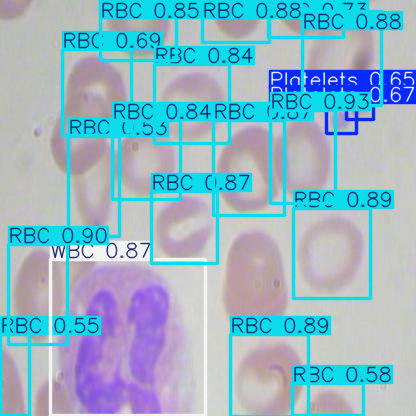

In [20]:
from PIL import Image
from ultralytics import YOLO

model_path = '/content/best.pt'
model = YOLO(model_path)

test_images = ["/content/BCCD-4/valid/images/BloodImage_00377_jpg.rf.0c8524be5de7a9ef2d1faa43043e0fe9.jpg"]
results = model.predict(test_images, conf=0.5)

# Visualize the results
for i, r in enumerate(results):
    im_bgr = r.plot()
    im_rgb = Image.fromarray(im_bgr[..., ::-1])
    r.show()

## With KNN


0: 416x416 1 Platelets, 16 RBCs, 1 WBC, 8.1ms
Speed: 0.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 416, 416)


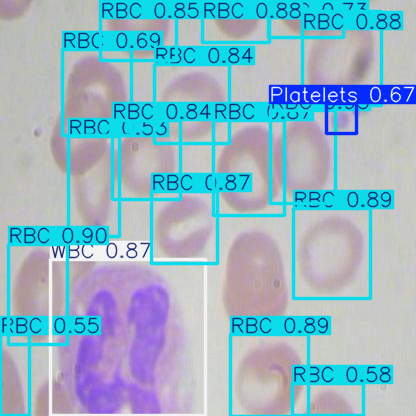

In [21]:
from PIL import Image
from ultralytics import YOLO

model_path = '/content/best.pt'
model = YOLO(model_path)

test_images = ["/content/BCCD-4/valid/images/BloodImage_00377_jpg.rf.0c8524be5de7a9ef2d1faa43043e0fe9.jpg"]
results = model.predict(test_images, conf=0.5, predictor=CustomPredictor)

# Visualize the results
for i, r in enumerate(results):
    im_bgr = r.plot()
    im_rgb = Image.fromarray(im_bgr[..., ::-1])
    r.show()
